# Практическая работа №5

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(10, 8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def get_metrics(y, y_preds):
    precision, recall, thresholds = precision_recall_curve(y, y_preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [7]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', RobustScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [11]:
tbl=pd.DataFrame(columns=['Threshold', 'F-Score', 'Precision', 'Recall', 'Action_cashflow', 'Cashflow'])

**RandomForest**

In [12]:
RandomForest_pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [13]:
#обучим наш пайплайн
_ = RandomForest_pipeline.fit(X_train, y_train)

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629
Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


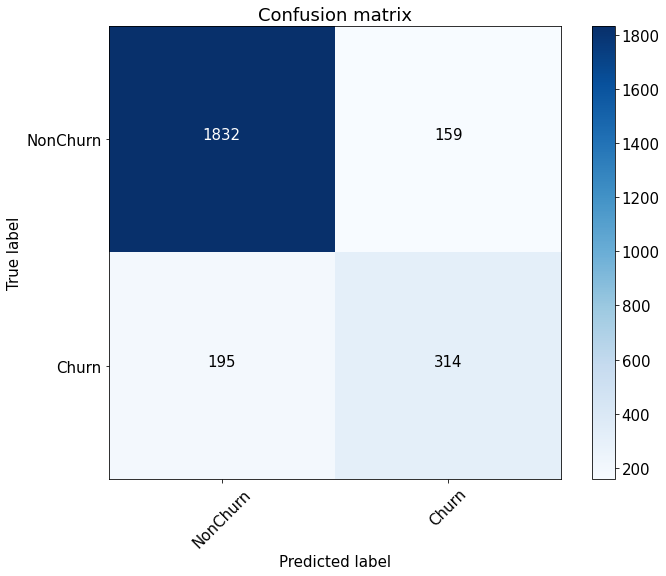

In [14]:
#наши прогнозы для тестовой выборки
preds = RandomForest_pipeline.predict_proba(X_test)[:, 1]

threshold, fscore, precision, recall = get_metrics(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (threshold, fscore, precision, recall))

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')

action_cashflow = cnf_matrix[1, 1]*2 - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 
lost_cashflow =  - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 - cnf_matrix[1, 0]*2
tbl.loc['RandomForest']=[threshold, fscore, precision, recall, action_cashflow, lost_cashflow]

**XGBoost**

In [15]:
XGBoost_pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, random_state = 42)),
])

In [16]:
#обучим наш пайплайн
_ = XGBoost_pipeline.fit(X_train, y_train)

[18:15:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Best Threshold=0.374072, F-Score=0.625, Precision=0.618, Recall=0.631
Confusion matrix, without normalization
[[1793  198]
 [ 189  320]]


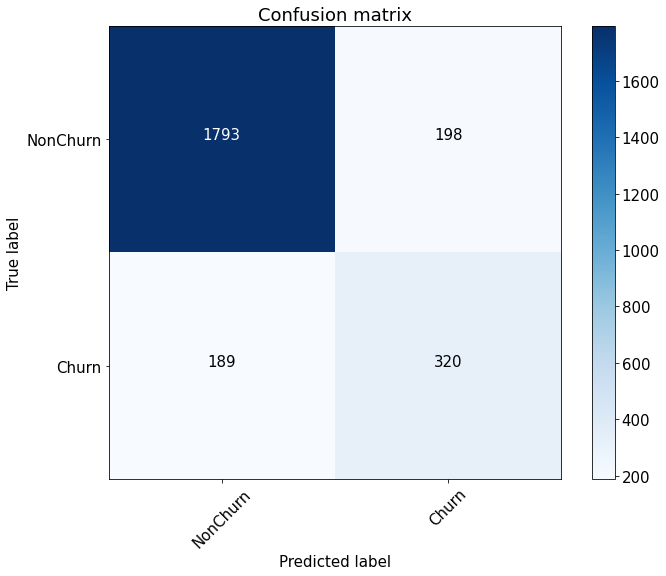

In [17]:
#наши прогнозы для тестовой выборки
preds = XGBoost_pipeline.predict_proba(X_test)[:, 1]

threshold, fscore, precision, recall = get_metrics(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (threshold, fscore, precision, recall))

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')

action_cashflow = cnf_matrix[1, 1]*2 - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 
lost_cashflow =  - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 - cnf_matrix[1, 0]*2
tbl.loc['XGBoost']=[threshold, fscore, precision, recall, action_cashflow, lost_cashflow]

**логистическая регрессия**

In [18]:
LogReg_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [19]:
#обучим наш пайплайн
_ = LogReg_pipeline.fit(X_train, y_train)

Best Threshold=0.289256, F-Score=0.509, Precision=0.462, Recall=0.568
Confusion matrix, without normalization
[[1654  337]
 [ 221  288]]


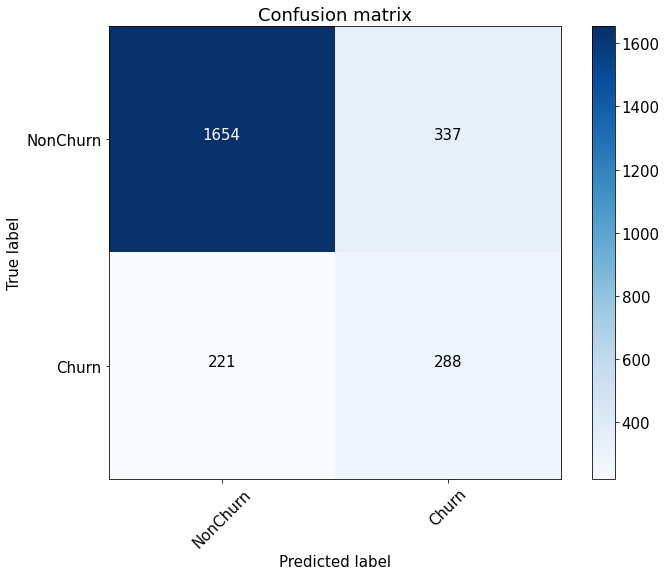

In [20]:
#наши прогнозы для тестовой выборки
preds = LogReg_pipeline.predict_proba(X_test)[:, 1]

threshold, fscore, precision, recall = get_metrics(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (threshold, fscore, precision, recall))

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')

action_cashflow = cnf_matrix[1, 1]*2 - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 
lost_cashflow =  - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 - cnf_matrix[1, 0]*2
tbl.loc['LogReg']=[threshold, fscore, precision, recall, action_cashflow, lost_cashflow]

In [21]:
tbl

,Threshold,F-Score,Precision,Recall,Action_cashflow,Cashflow
RandomForest,0.380000,0.640641,0.653061,0.628684,119.0,-899.0
XGBoost,0.374072,0.624514,0.618497,0.630648,131.0,-887.0
LogReg,0.289256,0.509251,0.461661,0.567780,67.0,-951.0


2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Расходы на привлечение равны
$$ 1 * (TP + FP)$$
Выручка от удержанных равна
$$ 2 * TP$$
**Результат привлечения будет**
$$ Action cashflow = 2*TP - 1*(TP + FP)$$

Можно посчитать сумму оттока денежных средств, если учесть, что удержанные продолжают приносить выручку 2 доллара, а ушедшие снижают выручку на 2 дорллара. 
**Тогда результат оттока** 
$$ Cashflow = -1*(TP + FP) - 2*FN $$

В обоих случаях результат лучше у модели **XGBoost**, а наиболей подходящей DS-метрикой является **Recall** 

4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

5. (опционально) Еще раз провести оценку экономической эффективности

In [22]:
params={'classifier__eta':[0.3, 0.4, 0.5],
        'classifier__gamma':[0, 1, 2],
        'classifier__max_depth':[4, 5, 6]
        }

In [23]:
grid = GridSearchCV(XGBoost_pipeline,
                    param_grid=params,
                    scoring='recall',
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)

[18:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:16:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:16:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:17:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:19:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:20:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:20:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [24]:
search.best_params_

{'classifier__eta': 0.3, 'classifier__gamma': 1, 'classifier__max_depth': 5}

[18:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Threshold=0.303487, F-Score=0.635, Precision=0.586, Recall=0.694
Confusion matrix, without normalization
[[1742  249]
 [ 157  352]]


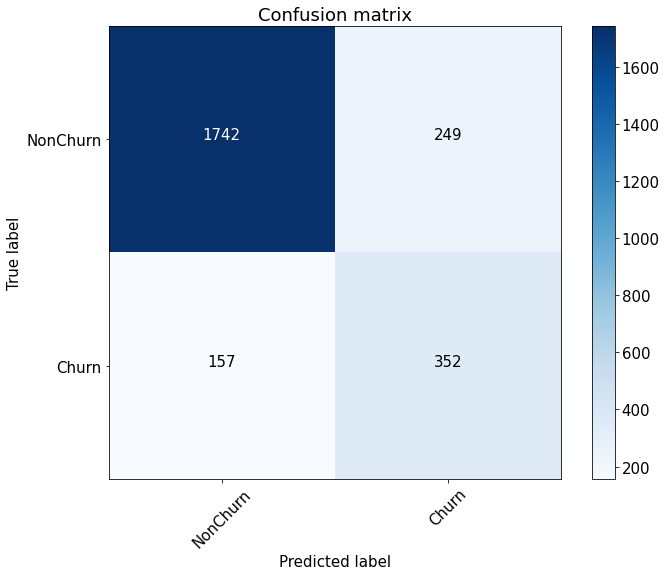

In [25]:
XGBoost_best_params_pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, 
                                     eta=0.3,
                                     gamma=1,
                                     max_depth=5,
                                     random_state = 42)),
])

#обучим наш пайплайн
_ = XGBoost_best_params_pipeline.fit(X_train, y_train)

#наши прогнозы для тестовой выборки
preds = XGBoost_best_params_pipeline.predict_proba(X_test)[:, 1]

threshold, fscore, precision, recall = get_metrics(y_test, preds)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (threshold, fscore, precision, recall))

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')

action_cashflow = cnf_matrix[1, 1]*2 - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 
lost_cashflow =  - (cnf_matrix[1, 0] + cnf_matrix[1, 1])*1 - cnf_matrix[1, 0]*2
tbl.loc['XGBoost_best_params']=[threshold, fscore, precision, recall, action_cashflow, lost_cashflow]

In [26]:
tbl

,Threshold,F-Score,Precision,Recall,Action_cashflow,Cashflow
RandomForest,0.380000,0.640641,0.653061,0.628684,119.0,-899.0
XGBoost,0.374072,0.624514,0.618497,0.630648,131.0,-887.0
LogReg,0.289256,0.509251,0.461661,0.567780,67.0,-951.0
XGBoost_best_params,0.303487,0.635464,0.586379,0.693517,195.0,-823.0


**Показатели экономической эффективности значительно улучшились после подбора параметров**